In [1]:
import sys
sys.path.append('../../src')

from common import common, transform, json
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.display import display
from display.video import Video
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
room_num = '09'
date = '20210304'
method = 'passing'

In [3]:
field_path = os.path.join(common.data_dir, 'field.png')

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_train = transform.Homography(p_video, p_field, field_raw.shape)

# Group Activity をロード

In [5]:
from common.json import GA_FORMAT
from group_activity.group_activity import GroupActivity

def make_group_activity(data, method):
    ga = GroupActivity(field_raw, method)
    ga.indicator_dict[method] = data[method]
    return ga

# 受け渡し
## 開始フレームと終了フレームを抽出する

In [6]:
name = 'pass3'
method = 'passing'
target_persons = {
    'pass1': [1, 2],
    'pass2': [0, 2],
    'pass3': [1, 2],
}

group_activity_json = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/group_activity.json'.format(room_num, date, name))
group_activity_data = json.load(group_activity_json)

In [7]:
ga = make_group_activity(group_activity_data, method)

In [15]:
from common.json import GA_FORMAT

preds = []
pre_pred = 0
last_true_frame = 0
for data in ga.indicator_dict[method]:
    persons = data[GA_FORMAT[method][1]]
    if persons[0] in target_persons[name] and persons[1] in target_persons[name]:
        frame_num = data[GA_FORMAT[method][0]]
        pred = data[GA_FORMAT[method][3]]
        preds.append(pred)

        if pre_pred == 0 and pred == 1:
            if frame_num - last_true_frame < 20:
                print(last_true_frame)
                print(frame_num)
                # 20フレーム以内に 1 が来たら間を穴埋めする
                for i in range(last_true_frame, frame_num + 1):
                    preds[i] = 1

        if pred == 1:
            last_true_frame = frame_num
            
        pre_pred = pred

In [16]:
start_indices = []
end_indices = []

pre_pred = 0
for frame_num, pred in enumerate(preds):
    if pre_pred == 0 and pred == 1:
        start_indices.append(frame_num)
    elif pre_pred == 1 and pred == 0:
        end_indices.append(frame_num)
    
    pre_pred = pred

In [17]:
start_indices

[84, 460, 1131]

In [18]:
end_indices

[289, 602, 1253]

## タイムシーケンスを作る

In [31]:
width = 800
def make_sequence(preds, start_indices, index, width=1200):
    fig = plt.figure(figsize=(width / 50.0, 1.0))
    ax = fig.add_subplot(
        111,
        xlim=(-10, len(preds) + 10), xticks=[],
        ylim=(-1.0, 1.0), yticks=[])

    xlim = 10 / len(preds)
    ax.axhline(0, xmin=xlim, xmax=(1 - xlim))

    for start_index in start_indices:
        ax.axvspan(
            xmin=(start_index - 1), xmax=(start_index + 1),
            ymin=0.2, ymax=0.8,
            color='orange')
        
    ax.axvline(index, color='red')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.close(fig)

    # fig to ndarray
    fig.canvas.draw()
    result_image = np.array(fig.canvas.renderer.buffer_rgba())
    result_image = cv2.cvtColor(result_image, cv2.COLOR_RGBA2RGB)
    
    return result_image

## ビデオと合成する

In [32]:
def combine_image(frame_raw, result_image):
    frame = frame_raw.copy()
    ratio = 1 - (frame.shape[1] - result_image.shape[1]) / frame.shape[1]
    size = (int(frame.shape[1] * ratio), int(frame.shape[0] * ratio))
    frame = cv2.resize(frame, size)
    frame = np.concatenate([frame, result_image], axis=0)
    return frame

In [33]:
# load video
video_path = common.data_dir + '{}/{}/{}/out/{}.mp4'.format(room_num, date, name, method)
video = Video(video_path)

# out video file path
out_path = common.data_dir + '{}/{}/{}/out/{}_result.mp4'.format(room_num, date, name, method)

frames = []
for frame_num in tqdm(range(video.frame_num)):
    # read frame
    frame_raw = video.read()
    
    result_image = make_sequence(preds, start_indices, frame_num)

    # append tracking result
    img = combine_image(frame_raw, result_image)
    frames.append(img)
    
print('writing videos into {} ...'.format(out_path))
video.write(frames, out_path, frames[0].shape[1::-1])

100%|██████████| 1302/1302 [00:31<00:00, 41.90it/s]


writing videos into /Users/koji/program/research/data/09/20210304/pass3/out/passing_result.mp4 ...


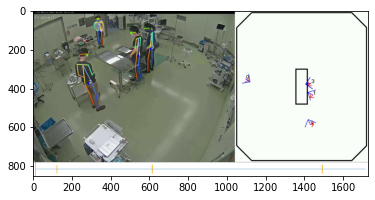

In [34]:
plt.imshow(frames[0])